### Predict fuel efficiency:
In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability. Here,  I use [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles.

Steps:
1. Prepare the data

In [320]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [321]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

##### 1. Data preposessing:
Attribute Information

    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)

In [322]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset=raw_dataset.copy()

In [323]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


2. clean data

In [324]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [325]:
dataset=dataset.dropna()
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

3. Convert Categorical Data

In [326]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='', dtype=int)
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


4. Split the data into training and test sets

In [327]:
train_dataset = dataset.sample(frac=.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.shape, test_dataset.shape

((314, 10), (78, 10))

5. Inspect the Data

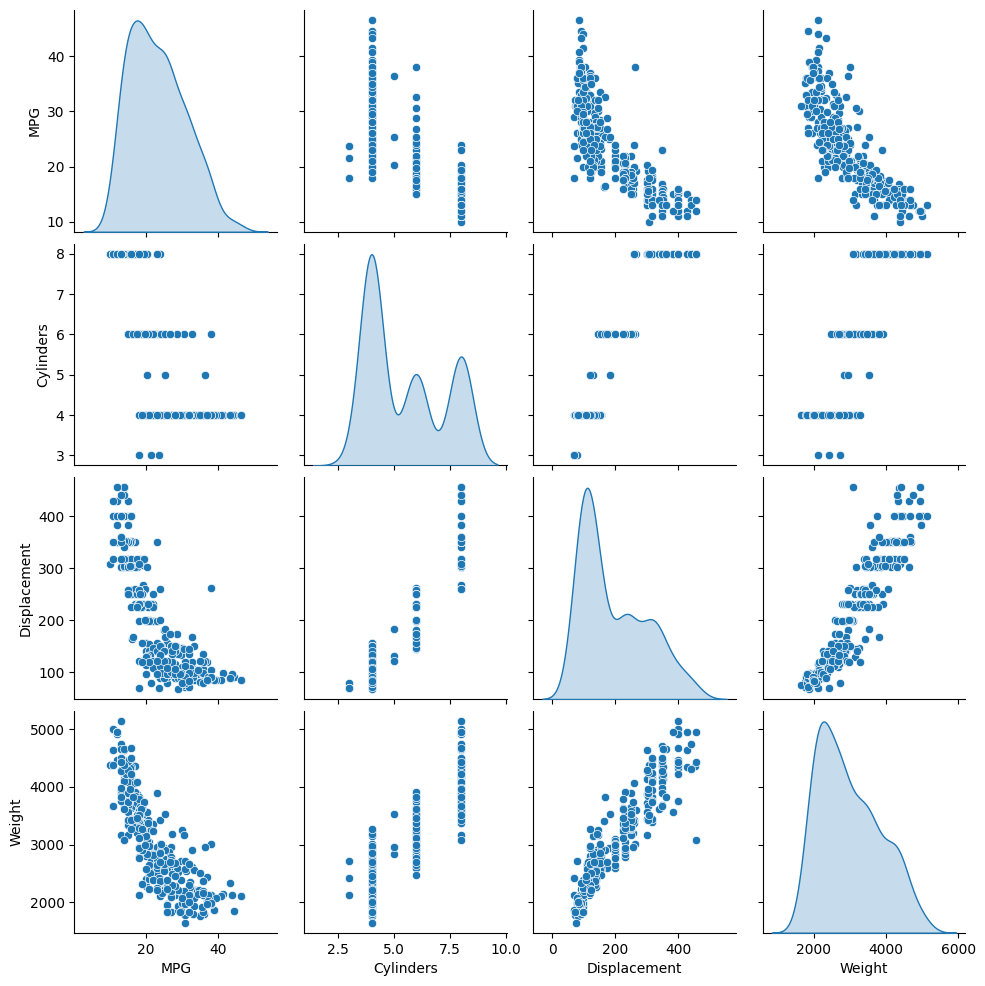

In [328]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

6. ***Split features from labels:***<br>
Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [329]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

##labels:
train_labels = train_features.pop("MPG")
test_labels = test_features.pop("MPG")
test_labels, train_features.shape, train_dataset.shape

(9      15.0
 25     10.0
 28      9.0
 31     25.0
 33     19.0
        ... 
 369    34.0
 375    36.0
 382    34.0
 384    32.0
 396    28.0
 Name: MPG, Length: 78, dtype: float64,
 (314, 9),
 (314, 10))

In [330]:
print(dataset.shape, train_dataset.shape, test_dataset.shape)
train_dataset.describe().transpose()[['mean','std']]

(392, 10) (314, 10) (78, 10)


,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


7. ***Normalized the data:***<br>
The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.This layer will shift and scale inputs into a distribution centered around 0 with standard deviation 1.
`tf.keras.layers.Normalization(axis, mean, varience, invert)`

    ***Algorithm:***

    1. Create the Normalized layer form the Keras Functional API
    2. Then calling `adapt` layer which is an alternative approach passing the mean and varience. `Normalization` layer should always either be adapted over a dataset or passed `mean` and `variance`.
        - `adapt(data, batch_size, step)`
        
    **Note:** When the layer is called, it returns the input data, with each feature independently normalized.

In [331]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy()) # this will store the actual mean to this layer.

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [332]:
first = np.array(train_features[:1])
# 
with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


### 2. Linear Regression:

 single-variable linear regression to predict `'MPG'` from `'Horsepower'`.
 Apply a linear transformation () to produce 1 output using a linear layer `(tf.keras.layers.Dense)`.

2.1. Normalize the feature:

In [333]:
feature="Horsepower"
single_feature = np.array(train_features[feature])
print(single_feature.shape, train_features.shape)

single_feature_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None) # define a 1D tensor
single_feature_normalizer.adapt(single_feature)

(314,) (314, 9)


2.2 Build the model

In [334]:
# Sequential model
single_feature_model = keras.models.Sequential([
    single_feature_normalizer,
    layers.Dense(units=1) # Linear Model
])

single_feature_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_25 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_22 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [335]:
single_feature_model.predict(single_feature[:10])

1/1 [==============================] - 0s 142ms/step


array([[ 1.108],
       [ 0.626],
       [-2.044],
       [ 1.553],
       [ 1.404],
       [ 0.551],
       [ 1.664],
       [ 1.404],
       [ 0.366],
       [ 0.626]], dtype=float32)

2.3. Loss and Optimize

In [336]:
loss = keras.losses.MeanAbsoluteError()
optim = tf.keras.optimizers.Adam(learning_rate = 0.1)
single_feature_model.compile(
    optimizer=optim,
    loss= loss)

2.4 Fit or Training

In [337]:
history = single_feature_model.fit(
    train_features[feature], train_labels,
    epochs=100,
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [338]:
# 
print(history.history)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

{'loss': [22.867752075195312, 22.063039779663086, 21.26372718811035, 20.4647274017334, 19.66458511352539, 18.862934112548828, 18.063461303710938, 17.263751983642578, 16.46270179748535, 15.663188934326172, 14.86361026763916, 14.062760353088379, 13.263422966003418, 12.463454246520996, 11.66297435760498, 10.864070892333984, 10.071818351745605, 9.291375160217285, 8.55015754699707, 7.865728378295898, 7.205194473266602, 6.5667829513549805, 5.9853386878967285, 5.476241111755371, 5.060919284820557, 4.774890422821045, 4.500601291656494, 4.298945903778076, 4.1419878005981445, 4.038520812988281, 3.952460527420044, 3.9065911769866943, 3.859851360321045, 3.847010612487793, 3.8297836780548096, 3.8241024017333984, 3.8151965141296387, 3.8109629154205322, 3.8055355548858643, 3.80389666557312, 3.8037376403808594, 3.8038904666900635, 3.807399272918701, 3.803048610687256, 3.806591510772705, 3.804896831512451, 3.8110220432281494, 3.8079733848571777, 3.805373191833496, 3.8027894496917725, 3.802428960800171,

,loss,val_loss,epoch
95,3.814224,4.154690,95
96,3.803545,4.178103,96
97,3.802819,4.191278,97
98,3.803655,4.221158,98
99,3.807422,4.214675,99


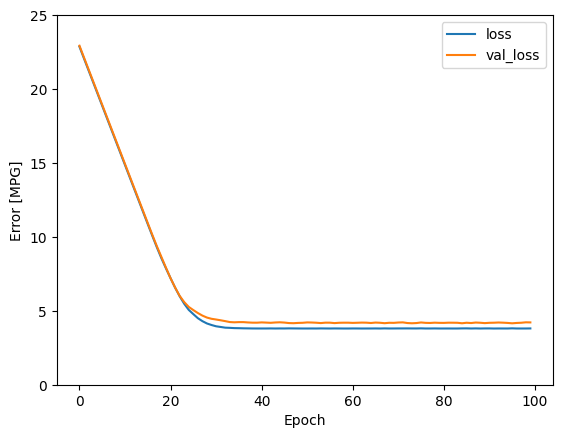

In [339]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 25])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    # plt.grid(True)
plot_loss(history)

In [340]:
test_results = {}

test_results['single_feature_model'] = single_feature_model.evaluate(
    test_features[feature],
    test_labels, verbose=0)

In [341]:
x = tf.linspace(0.0, 250, 251)
y = single_feature_model.predict(x)

8/8 [==============================] - 0s 5ms/step


In [342]:
def plot_singlefeatures(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

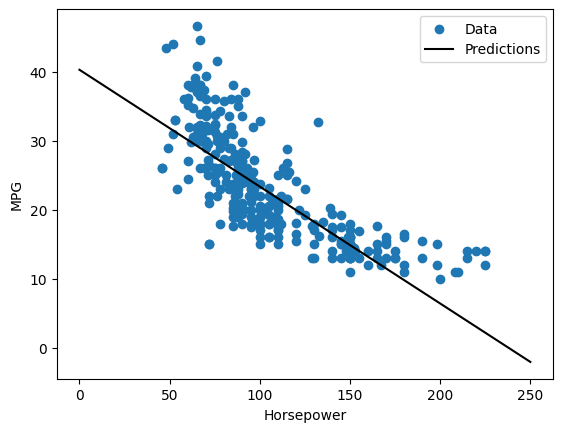

In [343]:
plot_singlefeatures(x,y)

### Multi-Feature Model

In [344]:
linear_model= tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
linear_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_24 (Normaliza  (None, 9)                19        
 tion)                                                           
                                                                 
 dense_23 (Dense)            (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [345]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 315ms/step


array([[ 1.873],
       [ 1.209],
       [-0.885],
       [ 1.071],
       [ 0.044],
       [ 0.445],
       [ 0.286],
       [-1.016],
       [ 0.905],
       [ 0.827]], dtype=float32)

In [346]:
# When you call the model, its weight matrices will be built
linear_model.layers[1].kernel

<tf.Variable 'dense_23/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.299],
       [-0.32 ],
       [ 0.116],
       [-0.559],
       [ 0.424],
       [-0.344],
       [-0.681],
       [-0.408],
       [ 0.347]], dtype=float32)>

In [347]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [348]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 16.4 s
Wall time: 14.9 s


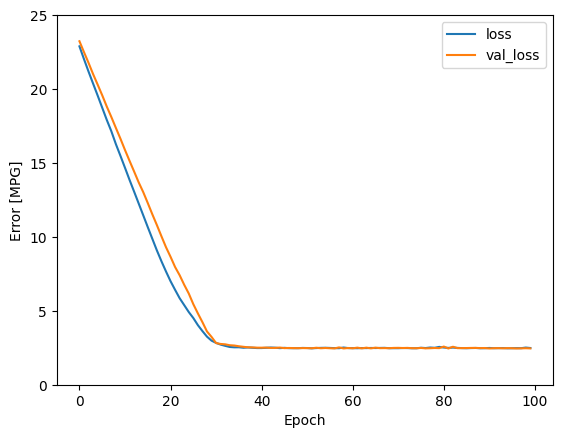

In [349]:
plot_loss(history)

In [350]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

### Regression with a deep neural network (DNN)

In [351]:
def build_compile_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        loss='mean_absolute_error',
        optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001))
    
    return model

In [352]:
dnn_single_feature_model  = build_compile_model(single_feature_normalizer)
dnn_single_feature_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_25 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_24 (Dense)            (None, 64)                128       
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [353]:
%%time
history = dnn_single_feature_model.fit(
    train_features[feature],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 18.8 s
Wall time: 17.2 s


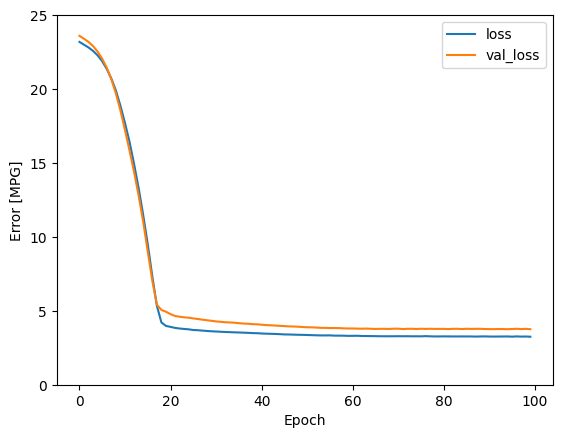

In [354]:
# plot history
plot_loss(history)

In [355]:
x = tf.linspace(0.0, 250, 251)
y = dnn_single_feature_model.predict(x)

8/8 [==============================] - 0s 6ms/step


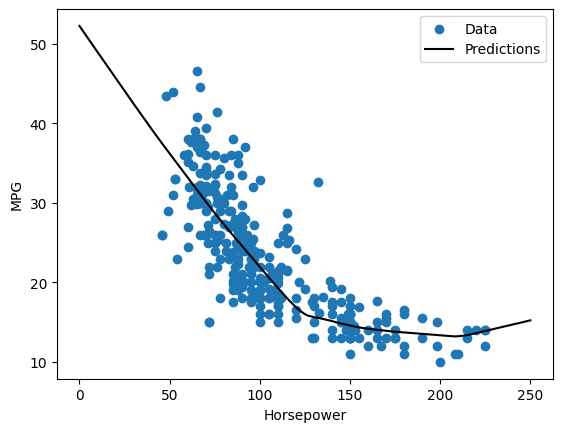

In [356]:
plot_singlefeatures(x, y)

In [357]:
test_results['dnn_single_feature_model'] = dnn_single_feature_model.evaluate(
    test_features[feature], test_labels,
    verbose=0)

#### Regression using a DNN and multiple inputs

In [358]:
dnn_model = build_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_24 (Normaliza  (None, 9)                19        
 tion)                                                           
                                                                 
 dense_27 (Dense)            (None, 64)                640       
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [359]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 19.2 s
Wall time: 17.7 s


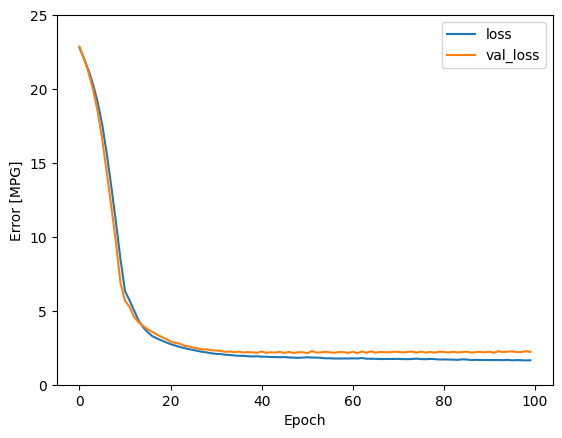

In [360]:
plot_loss(history)

In [361]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [362]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
single_feature_model,3.657027
linear_model,2.473700
dnn_single_feature_model,2.917799
dnn_model,1.684701


### Make predictions

3/3 [==============================] - 0s 5ms/step


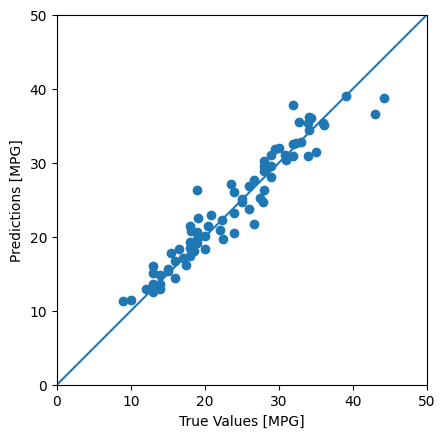

In [363]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

2. check the error distribution:

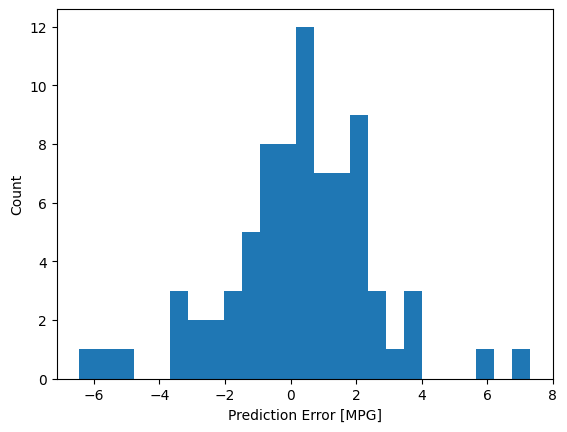

In [364]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')